In [5]:
import os
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [6]:
# Load the data

path = os.path.join(r'C:\Users\kentb\Desktop\PDM\data\products', 'BGCru_4000_6000.pkl')
file = open(path, "rb")
obs_data = pickle.load(file)
file.close()

In [110]:
n = np.arange(2,5,1)
print(n)
for n in n:
    print(n)

[2 3 4]
2
3
4


In [184]:
# Define some helper functions for the peak finding

# Check the harmonics of the peaks

def check_harmonics(freq):
    '''Check the main peak and their harmonics.
    '''
    main_peaks = np.array([])
    harmonics = np.array([])
    n = np.arange(2,10,1) # check for the first three harmonics
    freq = np.sort(freq) # sort the frequencies in ascending order
    for i in range(len(freq)):
        harmonic = 0
        main_peak = 0
        for j in range(i+1, len(freq)):
            for val in n:
                if np.isclose(freq[i], freq[j]/val, rtol=0.02):
                    harmonic = freq[j]
                    main_peak = freq[i]
            if harmonic != 0 and (harmonic not in harmonics):
                harmonics = np.append(harmonics, harmonic)
        if harmonic == 0:
            main_peak = freq[i]
        if (main_peak not in main_peaks) and (main_peak not in harmonics) and (np.isclose(main_peak, any(main_peaks), rtol=0.02) == False):
            main_peaks = np.append(main_peaks, main_peak)
    return main_peaks, harmonics

# Find the peaks in the power spectrum 
from scipy.signal import find_peaks

def get_peaks(freq, power, threshold, distance):
    '''Find the peaks in the power spectrum'''
    distance = 5*len(freq)/3000 # replace 3000 by self.baseline when put in class
    #threshold = ...              replace threshold p-value later.
    peaks, _ = find_peaks(power, height=threshold, distance=distance)
    freq_main_peaks, freq_harmonics = check_harmonics(freq[peaks])
    return freq_main_peaks, freq_harmonics

# Window power spectrum
from astropy.timeseries import LombScargle

def window_power_spectrum(time, min_freq, max_freq ):
    '''Find the main peaks of the window power spectrum'''
    ls = LombScargle(time,1,fit_mean=False,center_data=False)
    freqW, powerW = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)
    return freqW, powerW

# Plotting the power spectrum with peaks(or not)

def plot_power_spectrum(freqW, powerW, min_freq, max_freq, threshold,distance, peaks=False):
    fig, ax = plt.subplots(figsize=(16, 6))
    fig.subplots_adjust(bottom=0.2)
    ax.set_xscale('log')
    ax.plot(freqW, powerW, '-k', rasterized=True)
    ax.set(xlabel=r'Frequency [$Day^{-1}$]',
        ylabel=r'Window Power',
        xlim=(min_freq, max_freq));
    if peaks:
        main_peaks, harmonics = get_peaks(freqW, powerW, threshold, distance)
        for peak in main_peaks:
            ax.axvline(peak, color='Blue', linestyle='--',label = f'True peak: ({1/peak:.2f})',alpha=0.5)
        for harmonic in harmonics:
            ax.axvline(harmonic, color='Red', linestyle='--',label = f'Harmonic: ({1/harmonic:.2f})',alpha=0.5)
        ax.legend()
    plt.show()

c:\Users\kentb\miniconda3\envs\pdm\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


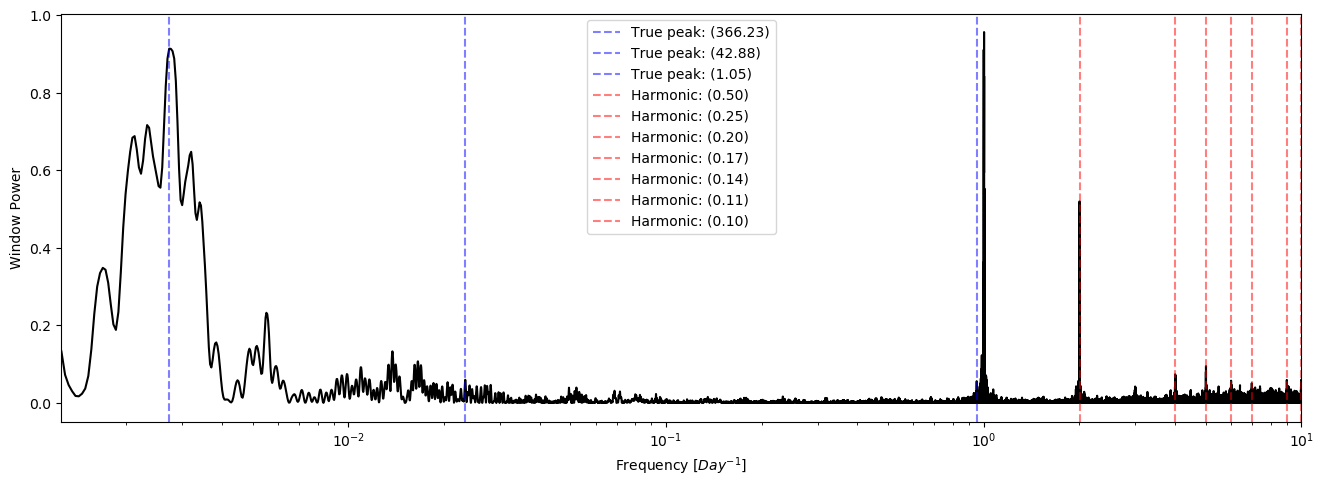

In [185]:
window_freq, window_power = window_power_spectrum(obs_data.time_series.times, 1/800, 10)
plot_power_spectrum(window_freq, window_power,1/800,10,0.05,200, peaks=True)

In [17]:
freq = np.asarray(obs_data.periodicity_detector.results_frequency['shift_periodogram'])
power = np.asarray(obs_data.periodicity_detector.results_power['shift_periodogram'])
signal = np.column_stack([freq, power])

not good... Need to find a better  way to find the peaks and to remove them.

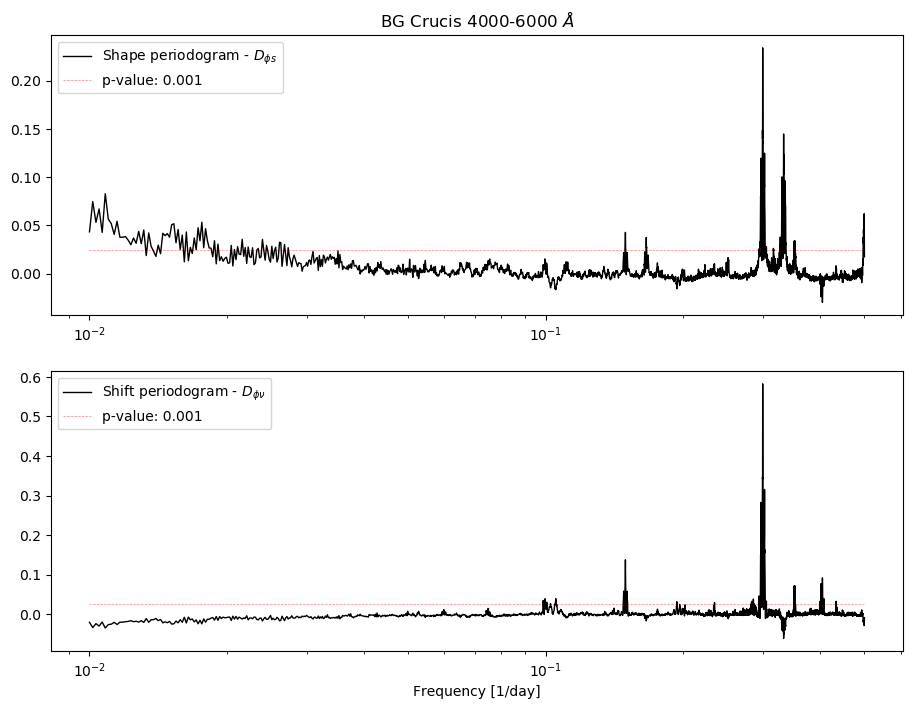

In [4]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=False,title=r"BG Crucis 4000-6000 $\AA$", log_scale=True)

In [54]:
# Plot all periodograms in a single plot by opening each pickle file and adding a subplot

results_dir = "C:\\Users\\kentb\\Desktop\\PDM\\thesis\\main\\S1D\\results\\"
results_files = sorted([folder for folder in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, folder))])

In [55]:
print(results_files)

['BGCru_4000_6000.pkl', 'BGCru_4200_4400.pkl', 'BGCru_4400_4600.pkl', 'BGCru_4600_4800.pkl', 'BGCru_4800_5000.pkl', 'BGCru_5000_5200.pkl', 'BGCru_5200_5400.pkl', 'BGCru_5400_5600.pkl', 'BGCru_5600_5800.pkl', 'BGCru_5800_6000.pkl', 'QZNor_4000_6000.pkl', 'QZNor_4200_4400.pkl', 'QZNor_4400_4600.pkl', 'QZNor_4600_4800.pkl', 'QZNor_4800_5000.pkl', 'QZNor_5000_5200.pkl', 'QZNor_5200_5400.pkl', 'QZNor_5400_5600.pkl', 'QZNor_5600_5800.pkl', 'QZNor_5800_6000.pkl', 'V0391_4000_6000.pkl', 'V0391_4200_4400.pkl', 'V0391_4400_4600.pkl', 'V0391_4600_4800.pkl', 'V0391_4800_5000.pkl', 'V0391_5000_5200.pkl', 'V0391_5200_5400.pkl', 'V0391_5400_5600.pkl', 'V0391_5600_5800.pkl', 'V0391_5800_6000.pkl']


In [ ]:
for file in results_files:
    file = open(results_dir + file, "rb")
    obs_data = pickle.load(file)
    obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=False,title=str(file).split('\\')[-1], log_scale=False)
    file.close()